In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

# Pre-req steps: from 01_exploration.ipynb

In [5]:
# read csv
df = pd.read_csv('../data/heart.csv')

# we split the data first, 
target_col = 'target'

X = df.drop(columns=target_col)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

# get categorical column
cat_cols = []
target_col = 'target'

for c in df.columns:
    if c == target_col:
        continue
    if df[c].dtype == "object":
        cat_cols.append(c)
    elif pd.api.types.is_integer_dtype(X_train[c]) and X_train[c].nunique() <= 15:
        cat_cols.append(c)

# encoded data frame
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

num_cols = [c for c in X_train_enc.columns if c not in
            [col for col in X_train_enc.columns if any(col.startswith(f"{cc}_") for cc in cat_cols)]
           ]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

# scaling/normalizing the numerical values
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols]  = scaler.transform(X_test_enc[num_cols])

# 2. Model Training

## 2.1 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_enc, y_train)

y_pred_log_reg = log_reg.predict(X_test_enc)

log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)

print(f'Logistic Regression Accuracy: {log_reg_accuracy:.4f}')

print(classification_report(y_test, y_pred_log_reg, target_names=['1','0']))

Logistic Regression Accuracy: 0.8488
              precision    recall  f1-score   support

           1       0.88      0.80      0.84       100
           0       0.82      0.90      0.86       105

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205



## 2.2 Decision Tree Classifier

In [7]:
tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X_train_enc, y_train)

y_pred_tree = tree_clf.predict(X_test_enc)

tree_accuracy = accuracy_score(y_test, y_pred_tree)

print(f'Decision Tree Accuracy: {tree_accuracy:.4f}')

print(classification_report(y_test, y_pred_tree, target_names=['1', '0']))

Decision Tree Accuracy: 0.9854
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       100
           0       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



## 2.3 KNN

In [8]:
knn = KNeighborsClassifier()

knn.fit(X_train_enc, y_train)

y_pred_knn = knn.predict(X_test_enc)

knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f'KNN Accuracy: {knn_accuracy:.4f}')

print(classification_report(y_test, y_pred_knn, target_names=['1', '0']))

KNN Accuracy: 0.8244
              precision    recall  f1-score   support

           1       0.81      0.84      0.82       100
           0       0.84      0.81      0.83       105

    accuracy                           0.82       205
   macro avg       0.82      0.82      0.82       205
weighted avg       0.83      0.82      0.82       205



# 3. Hyperparameter Tuning

## 3.1 GridSearchCV on KNN

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': range(1, 31),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,          
    scoring='f1',
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_enc, y_train)

print("BEST HYPERPARAMETERS:")
best_params = grid_search.best_params_
print(best_params)

print("BEST F1 SCORE (from cross-validation):")
best_score = grid_search.best_score_
print(f"F1 Score: {best_score:.4f}")

Fitting 3 folds for each of 120 candidates, totalling 360 fits
BEST HYPERPARAMETERS:
{'knn__metric': 'euclidean', 'knn__n_neighbors': 16, 'knn__weights': 'distance'}
BEST F1 SCORE (from cross-validation):
F1 Score: 0.9832


# 4. Model Evaluation 

## 4.1 Confusion Matrices for Logistic Regression, 

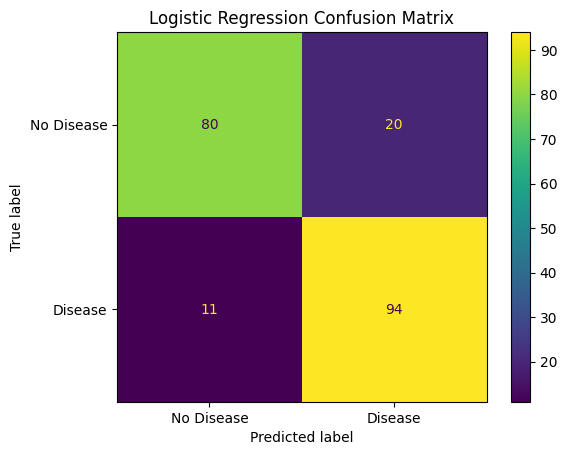

In [23]:
# Logistic regression cm
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=['No Disease', 'Disease'])
disp_log_reg.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

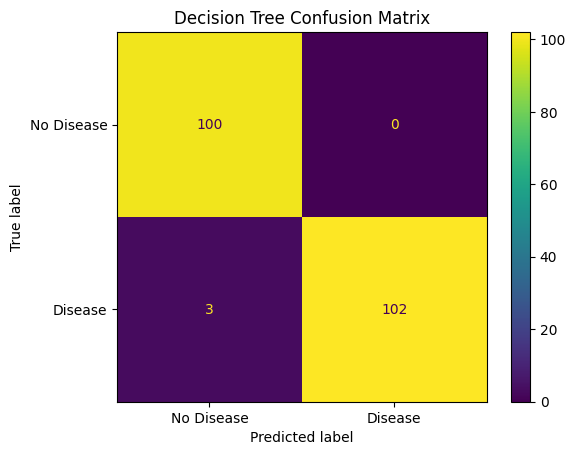

In [22]:
# Decision tree cm
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['No Disease', 'Disease'])
disp_tree.plot()
plt.title('Decision Tree Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'KNN Confusion Matrix')

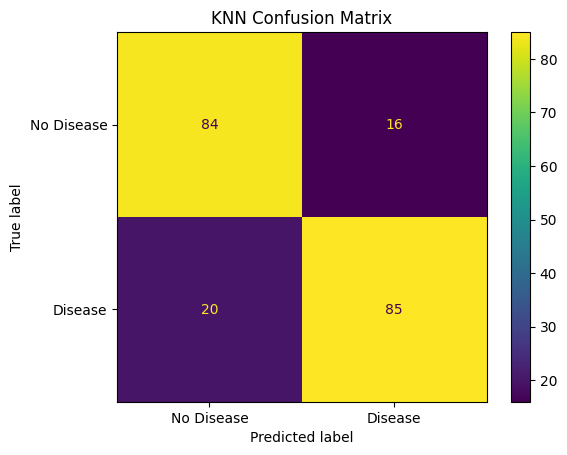

In [24]:
# KNN cm
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['No Disease', 'Disease'])
disp_knn.plot()
plt.title('KNN Confusion Matrix')

## 4.2 Classification Reports/ Precision, Recall, F1 Scores

In [13]:
# Logistic Regression Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Disease','No Disease']))

# Decision Tree Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree, target_names=['Disease','No Disease']))

# KNN Classification Report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Disease','No Disease']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Disease       0.88      0.80      0.84       100
  No Disease       0.82      0.90      0.86       105

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205

Decision Tree Classification Report:
              precision    recall  f1-score   support

     Disease       0.97      1.00      0.99       100
  No Disease       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

KNN Classification Report:
              precision    recall  f1-score   support

     Disease       0.81      0.84      0.82       100
  No Disease       0.84      0.81      0.83       105

    accuracy                           0.82       205
   macro avg       0.

## 4.3 ROC curves and AUC scores

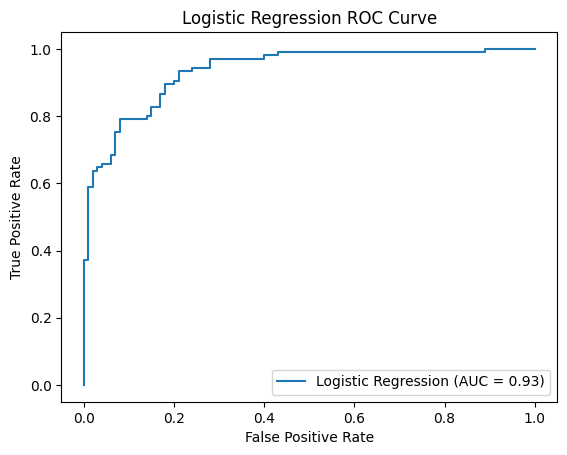

In [14]:
# Logistic Regression ROC-AUC
y_prob_log_reg = log_reg.predict_proba(X_test_enc)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

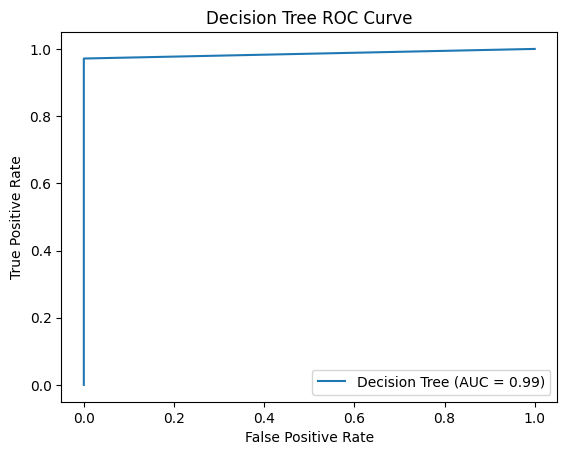

In [15]:
# Decision Tree ROC-AUC
y_prob_tree = tree_clf.predict_proba(X_test_enc)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
roc_auc_tree = roc_auc_score(y_test, y_prob_tree)
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.title('Decision Tree ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

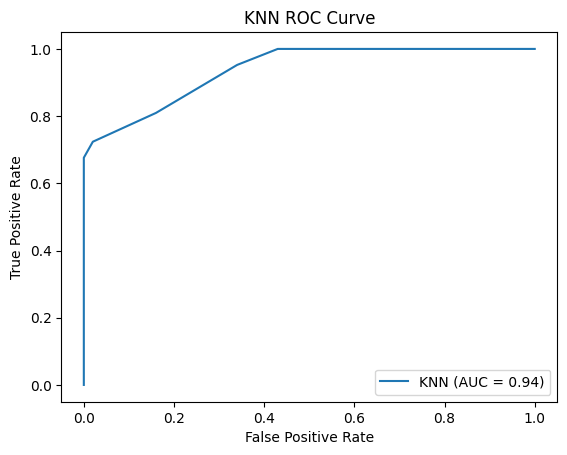

In [16]:
# KNN ROC-AUC
y_prob_knn = knn.predict_proba(X_test_enc)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.title('KNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## 4.4 Model Comparison Table/ Visualization

Model Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.848780,0.824561,0.895238,0.858447,0.934952
1,Decision Tree,0.985366,1.000000,0.971429,0.985507,0.985714
2,KNN,0.824390,0.841584,0.809524,0.825243,0.937762


Text(0.5, 1.0, 'KNN')

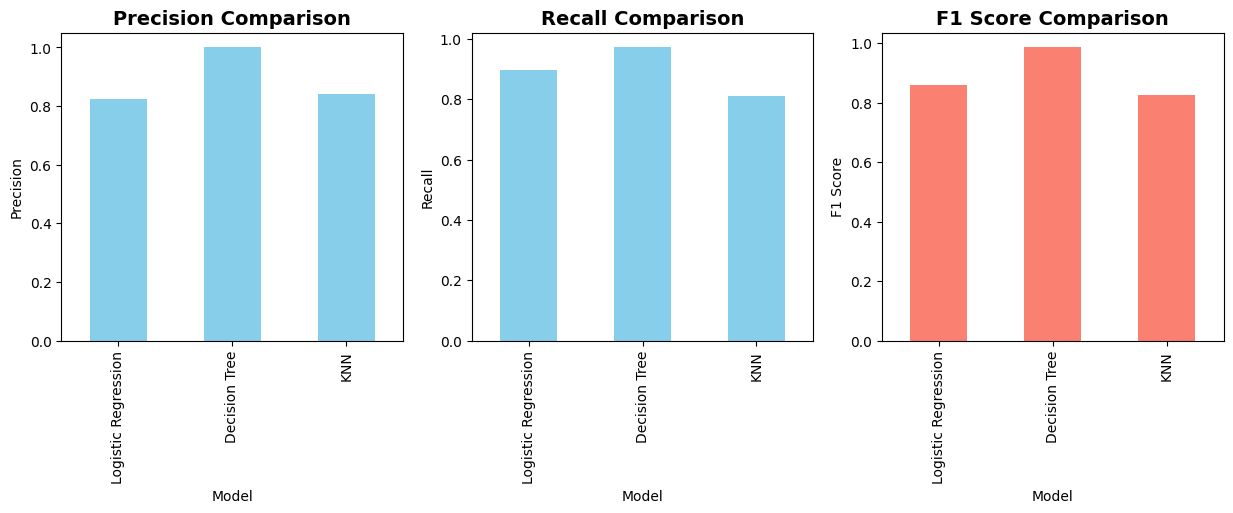

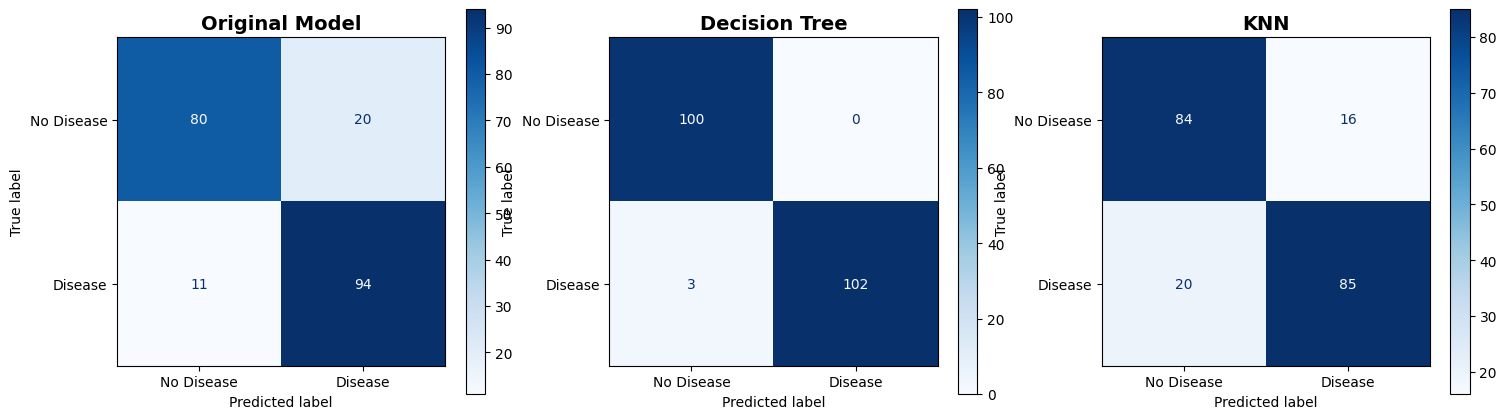

In [27]:
# Model Comparison Table
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'KNN'],
    'Accuracy': [log_reg_accuracy, tree_accuracy, knn_accuracy],
    'Precision': [
        precision_score(y_test, y_pred_log_reg),
        precision_score(y_test, y_pred_tree),
        precision_score(y_test, y_pred_knn)
    ],
    'Recall': [
        recall_score(y_test, y_pred_log_reg),
        recall_score(y_test, y_pred_tree),
        recall_score(y_test, y_pred_knn)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_log_reg),
        f1_score(y_test, y_pred_tree),
        f1_score(y_test, y_pred_knn)
    ],
    'ROC-AUC': [roc_auc_log_reg, roc_auc_tree, roc_auc_knn]
})
print("Model Comparison:")
display(model_comparison)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Precision comparison
model_comparison.plot(x='Model', y='Precision', kind='bar', ax=axes[0],
                   color='skyblue', legend=False)
axes[0].set_title('Precision Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Precision')

# Recall comparison
model_comparison.plot(x='Model', y='Recall', kind='bar', ax=axes[1],
                   color='skyblue', legend=False)
axes[1].set_title('Recall Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Recall')

# F1 Score comparison
model_comparison.plot(x='Model', y='F1 Score', kind='bar', ax=axes[2],
                   color='salmon', legend=False)
axes[2].set_title('F1 Score Comparison', fontweight='bold', fontsize=14)
axes[2].set_ylabel('F1 Score')


# Side-by-side confusion matrices
# Logistic Regression cm
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=['No Disease', 'Disease'])
disp1.plot(cmap='Blues', values_format='d', ax=axes[0])
axes[0].set_title('Original Model', fontweight='bold', fontsize=14)

# Decision Tree cm
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['No Disease', 'Disease'])
disp2.plot(cmap='Blues', values_format='d',
                ax=axes[1])
axes[1].set_title('Decision Tree', fontweight='bold', fontsize=14)

# KNN cm
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['No Disease', 'Disease'])
disp3.plot(cmap='Blues', values_format='d',
                ax=axes[2])
axes[2].set_title('KNN', fontweight='bold', fontsize=14)


Final model selected is Decision Tree for high performance metrics including high recall.

## 4.5 Error analysis for Models (Not required)

Error analysis for Logistic Regression


,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.00000,20.00000
mean,0.053117,0.166127,-0.076779,0.317342,-0.549714,0.700000,0.250000,0.050000,0.300000,0.100000,...,0.150000,0.400000,0.550000,0.250000,0.100000,0.050000,0.0,0.0,0.65000,0.35000
std,0.850371,1.184047,0.897088,0.722719,0.470614,0.470162,0.444262,0.223607,0.470162,0.307794,...,0.366348,0.502625,0.510418,0.444262,0.307794,0.223607,0.0,0.0,0.48936,0.48936
min,-1.592709,-1.272121,-1.890741,-1.041369,-0.914451,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.00000
25%,-0.622946,-0.892096,-0.555811,0.012991,-0.914451,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.00000
50%,0.346817,0.014117,-0.136537,0.436909,-0.830603,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,1.00000,0.00000
75%,0.568477,1.095727,0.542976,0.839087,-0.201746,1.000000,0.250000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.250000,0.000000,0.000000,0.0,0.0,1.00000,1.00000
max,1.178042,2.235802,1.598389,1.393441,0.259417,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.00000,1.00000


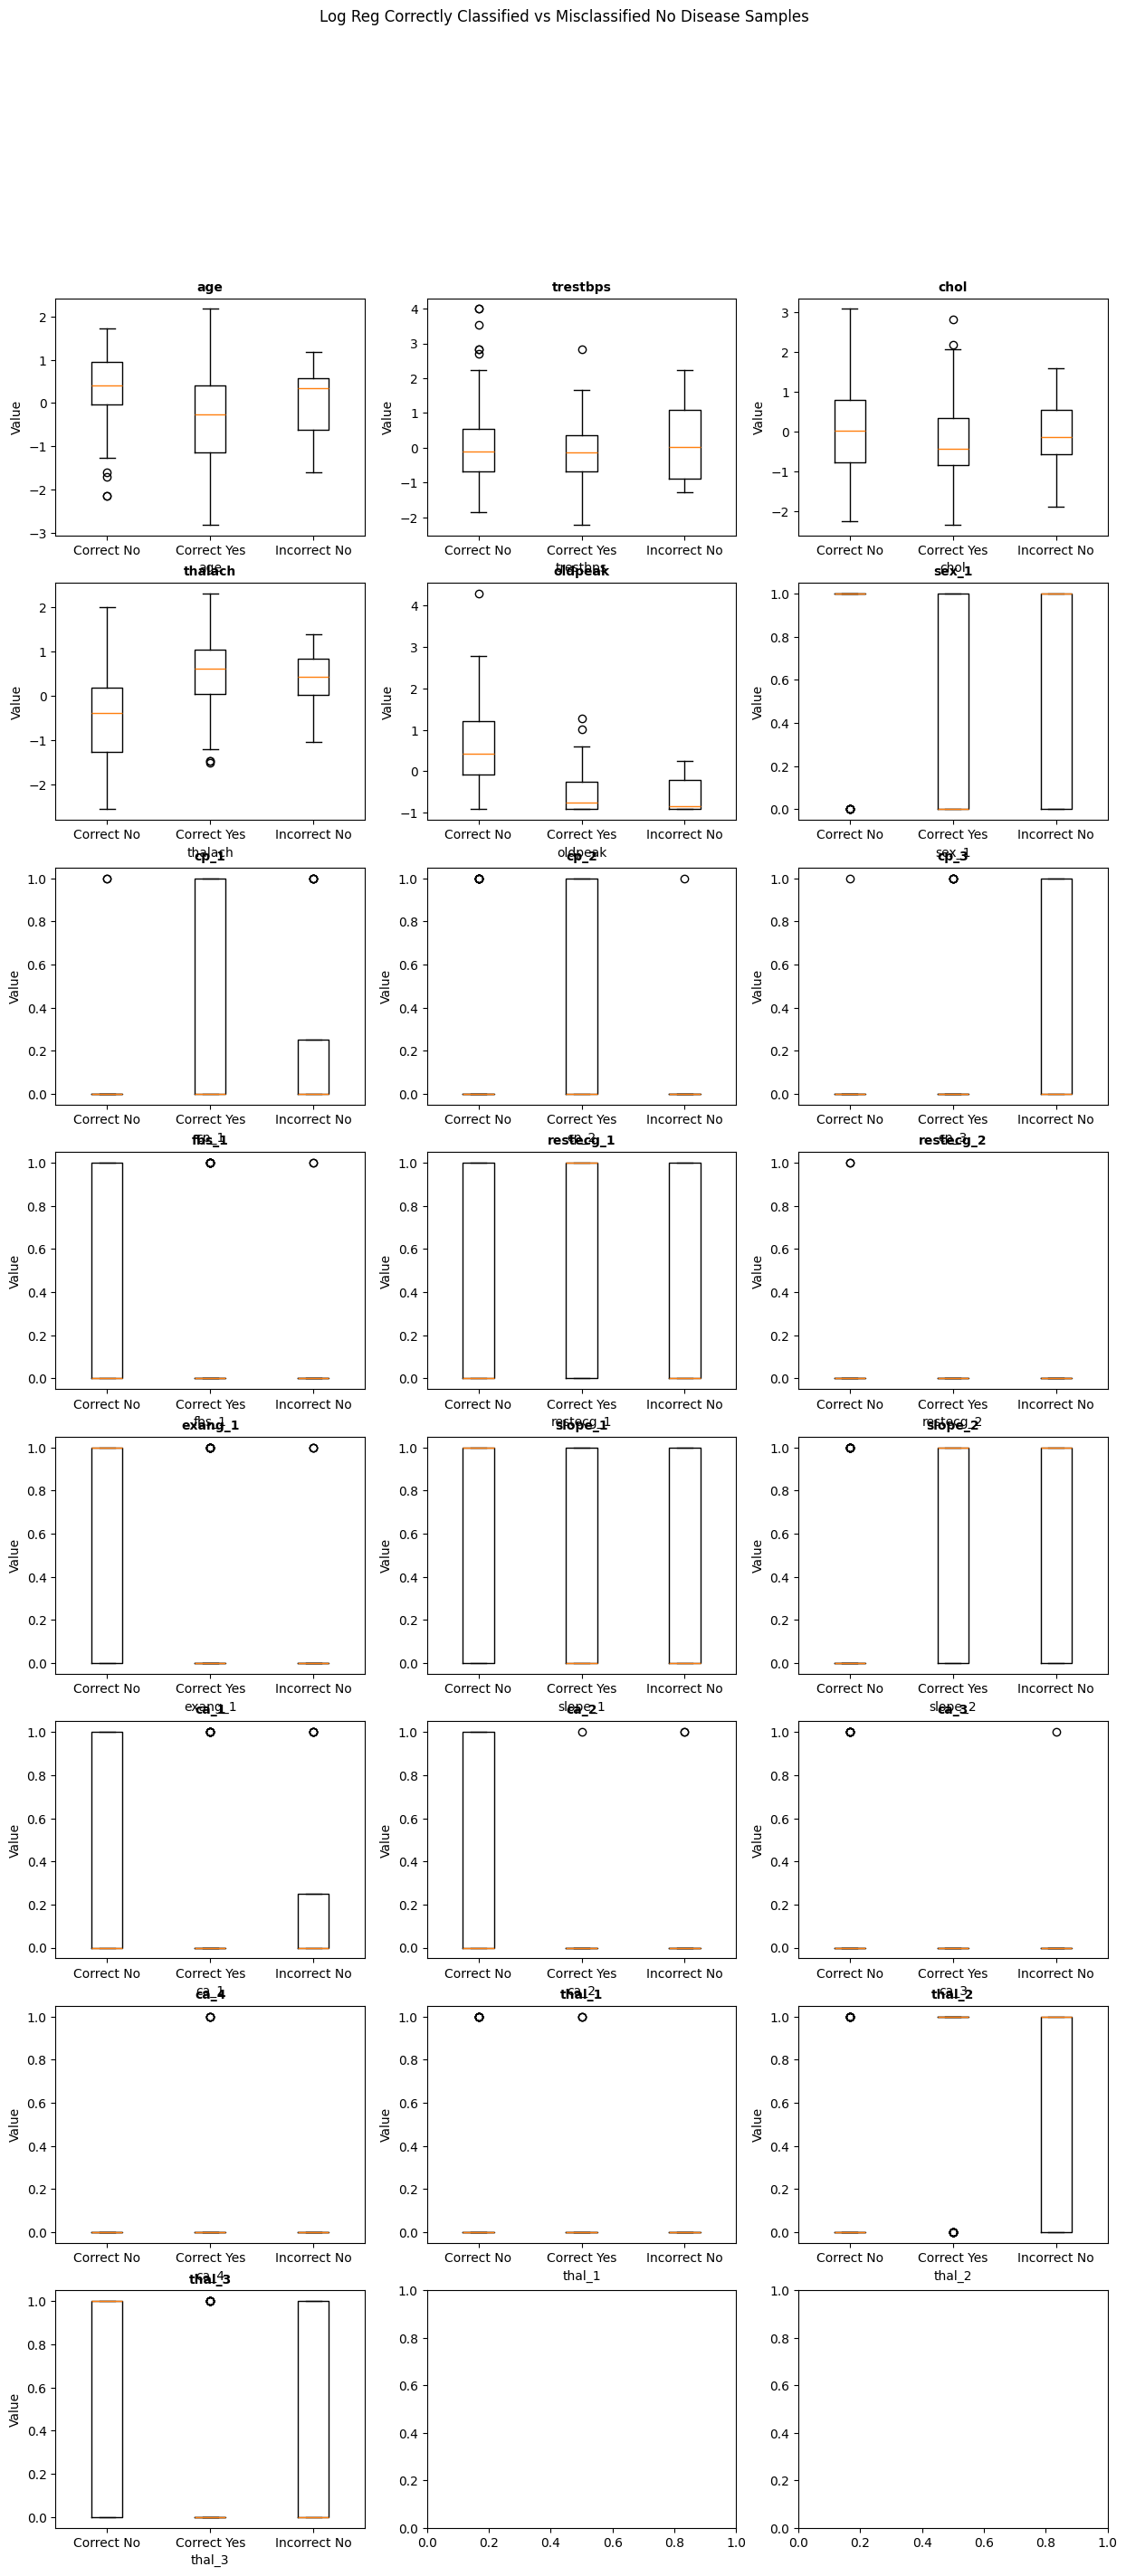

In [84]:
# Error analysis for logistic regression
misclassified_indices = np.where(y_test != y_pred_log_reg)[0]

# misclassified as no disease (false negative)
misclassified_no_disease_indices = misclassified_indices[y_test.iloc[misclassified_indices] == 0]
misclassified_no_disease_samples = X_test_enc.iloc[misclassified_no_disease_indices]

# correctly classified samples
correct_indices = np.where(y_test == y_pred_log_reg)[0]
# correctly classified as having disease
correct_disease_indices = correct_indices[y_test.iloc[correct_indices] == 1]
correct_disease_samples = X_test_enc.iloc[correct_disease_indices]
# correctly classified as no disease
correct_no_disease_indices = correct_indices[y_test.iloc[correct_indices] == 0]
correct_no_disease_samples = X_test_enc.iloc[correct_no_disease_indices]

print("Error analysis for Logistic Regression")
display(misclassified_no_disease_samples.describe())

# plot misclassified disease (false negative) vs correct for all features
# 22 columns
fig, axes = plt.subplots(8, 3, figsize=(15, 32))
plt.suptitle('Log Reg Correctly Classified vs Misclassified No Disease Samples')
for i, col in enumerate(X_test_enc.columns):
    ax = axes[i // 3, i % 3]
    # seaborn kde plots
    ax.boxplot([correct_no_disease_samples[col], correct_disease_samples[col], misclassified_no_disease_samples[col]],
               labels=['Correct No', 'Correct Yes', 'Incorrect No'])
    ax.set_title(col, fontweight='bold', fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel('Value')


Error analysis for Decision Tree


,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
mean,2.175513,-0.687467,0.422495,-1.215284,-0.746756,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.175513,-0.687467,0.422495,-1.215284,-0.746756,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,2.175513,-0.687467,0.422495,-1.215284,-0.746756,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,2.175513,-0.687467,0.422495,-1.215284,-0.746756,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,2.175513,-0.687467,0.422495,-1.215284,-0.746756,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
max,2.175513,-0.687467,0.422495,-1.215284,-0.746756,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


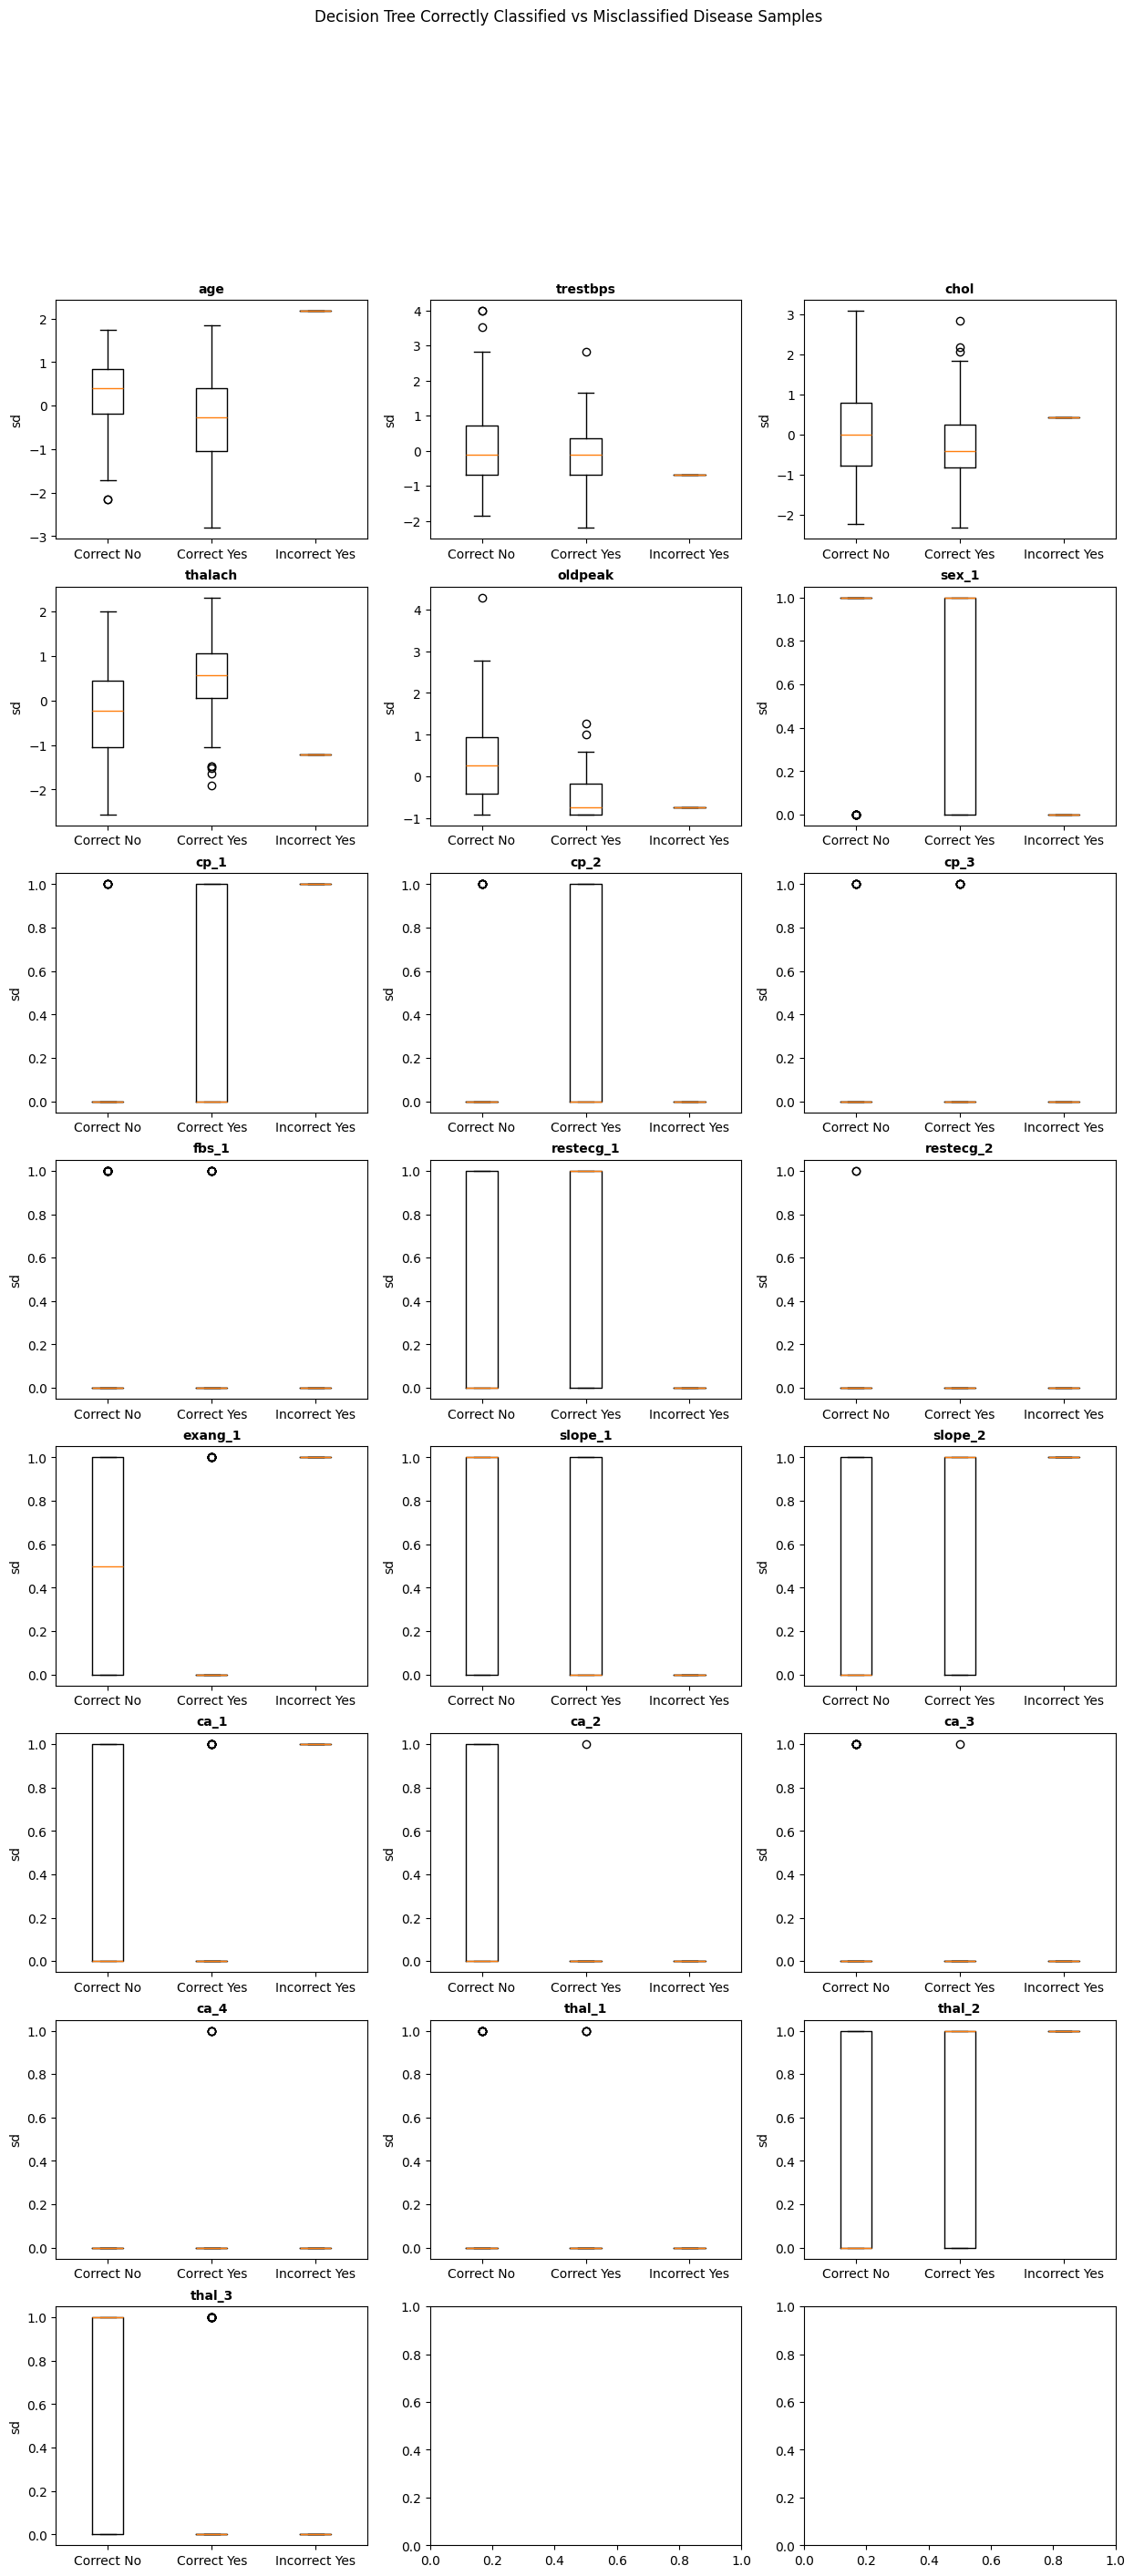

In [ ]:
# Error analysis for decision tree
misclassified_indices = np.where(y_test != y_pred_tree)[0]

# misclassified as disease (false positive)
misclassified_disease_indices = misclassified_indices[y_test.iloc[misclassified_indices] == 1]
misclassified_disease_samples = X_test_enc.iloc[misclassified_disease_indices]

# correctly classified samples
correct_indices = np.where(y_test == y_pred_tree)[0]
# correctly classified as having disease
correct_disease_indices = correct_indices[y_test.iloc[correct_indices] == 1]
correct_disease_samples = X_test_enc.iloc[correct_disease_indices]
# correctly classified as no disease
correct_no_disease_indices = correct_indices[y_test.iloc[correct_indices] == 0]
correct_no_disease_samples = X_test_enc.iloc[correct_no_disease_indices]

print("Error analysis for Decision Tree")
display(misclassified_disease_samples.describe())

# plot misclassified disease (false positive) vs correct for all features
# 22 columns
fig, axes = plt.subplots(8, 3, figsize=(15, 32))
plt.suptitle('Decision Tree Correctly Classified vs Misclassified Disease Samples')
for i, col in enumerate(X_test_enc.columns):
    ax = axes[i // 3, i % 3]
    ax.boxplot([correct_no_disease_samples[col], correct_disease_samples[col], misclassified_disease_samples[col]],
               labels=['Correct No', 'Correct Yes', 'Incorrect Yes'])
    
    ax.set_title(col, fontweight='bold', fontsize=10)

Error analysis for Decision Tree


,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0000,16.0000,16.000000,16.000000,...,16.000,16.000,16.000000,16.000000,16.000000,16.0000,16.0,16.000000,16.000000,16.000000
mean,0.429940,-0.132046,0.202014,-0.030488,-0.222708,0.812500,0.0625,0.0625,0.187500,0.187500,...,0.375,0.625,0.312500,0.250000,0.250000,0.0625,0.0,0.125000,0.500000,0.250000
std,0.793551,1.467625,0.818911,0.866599,0.837078,0.403113,0.2500,0.2500,0.403113,0.403113,...,0.500,0.500,0.478714,0.447214,0.447214,0.2500,0.0,0.341565,0.516398,0.447214
min,-1.149389,-1.856775,-0.965447,-1.867466,-0.914451,0.000000,0.0000,0.0000,0.000000,0.000000,...,0.000,0.000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000
25%,0.152864,-1.272121,-0.454607,-0.682670,-0.914451,1.000000,0.0000,0.0000,0.000000,0.000000,...,0.000,0.000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000
50%,0.513062,-0.336675,0.258640,0.306472,-0.411365,1.000000,0.0000,0.0000,0.000000,0.000000,...,0.000,1.000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.500000,0.000000
75%,1.011797,0.686469,0.846588,0.436909,-0.075974,1.000000,0.0000,0.0000,0.000000,0.000000,...,1.000,1.000,1.000000,0.250000,0.250000,0.0000,0.0,0.000000,1.000000,0.250000
max,1.399703,2.235802,1.521281,1.219526,1.936370,1.000000,1.0000,1.0000,1.000000,1.000000,...,1.000,1.000,1.000000,1.000000,1.000000,1.0000,0.0,1.000000,1.000000,1.000000


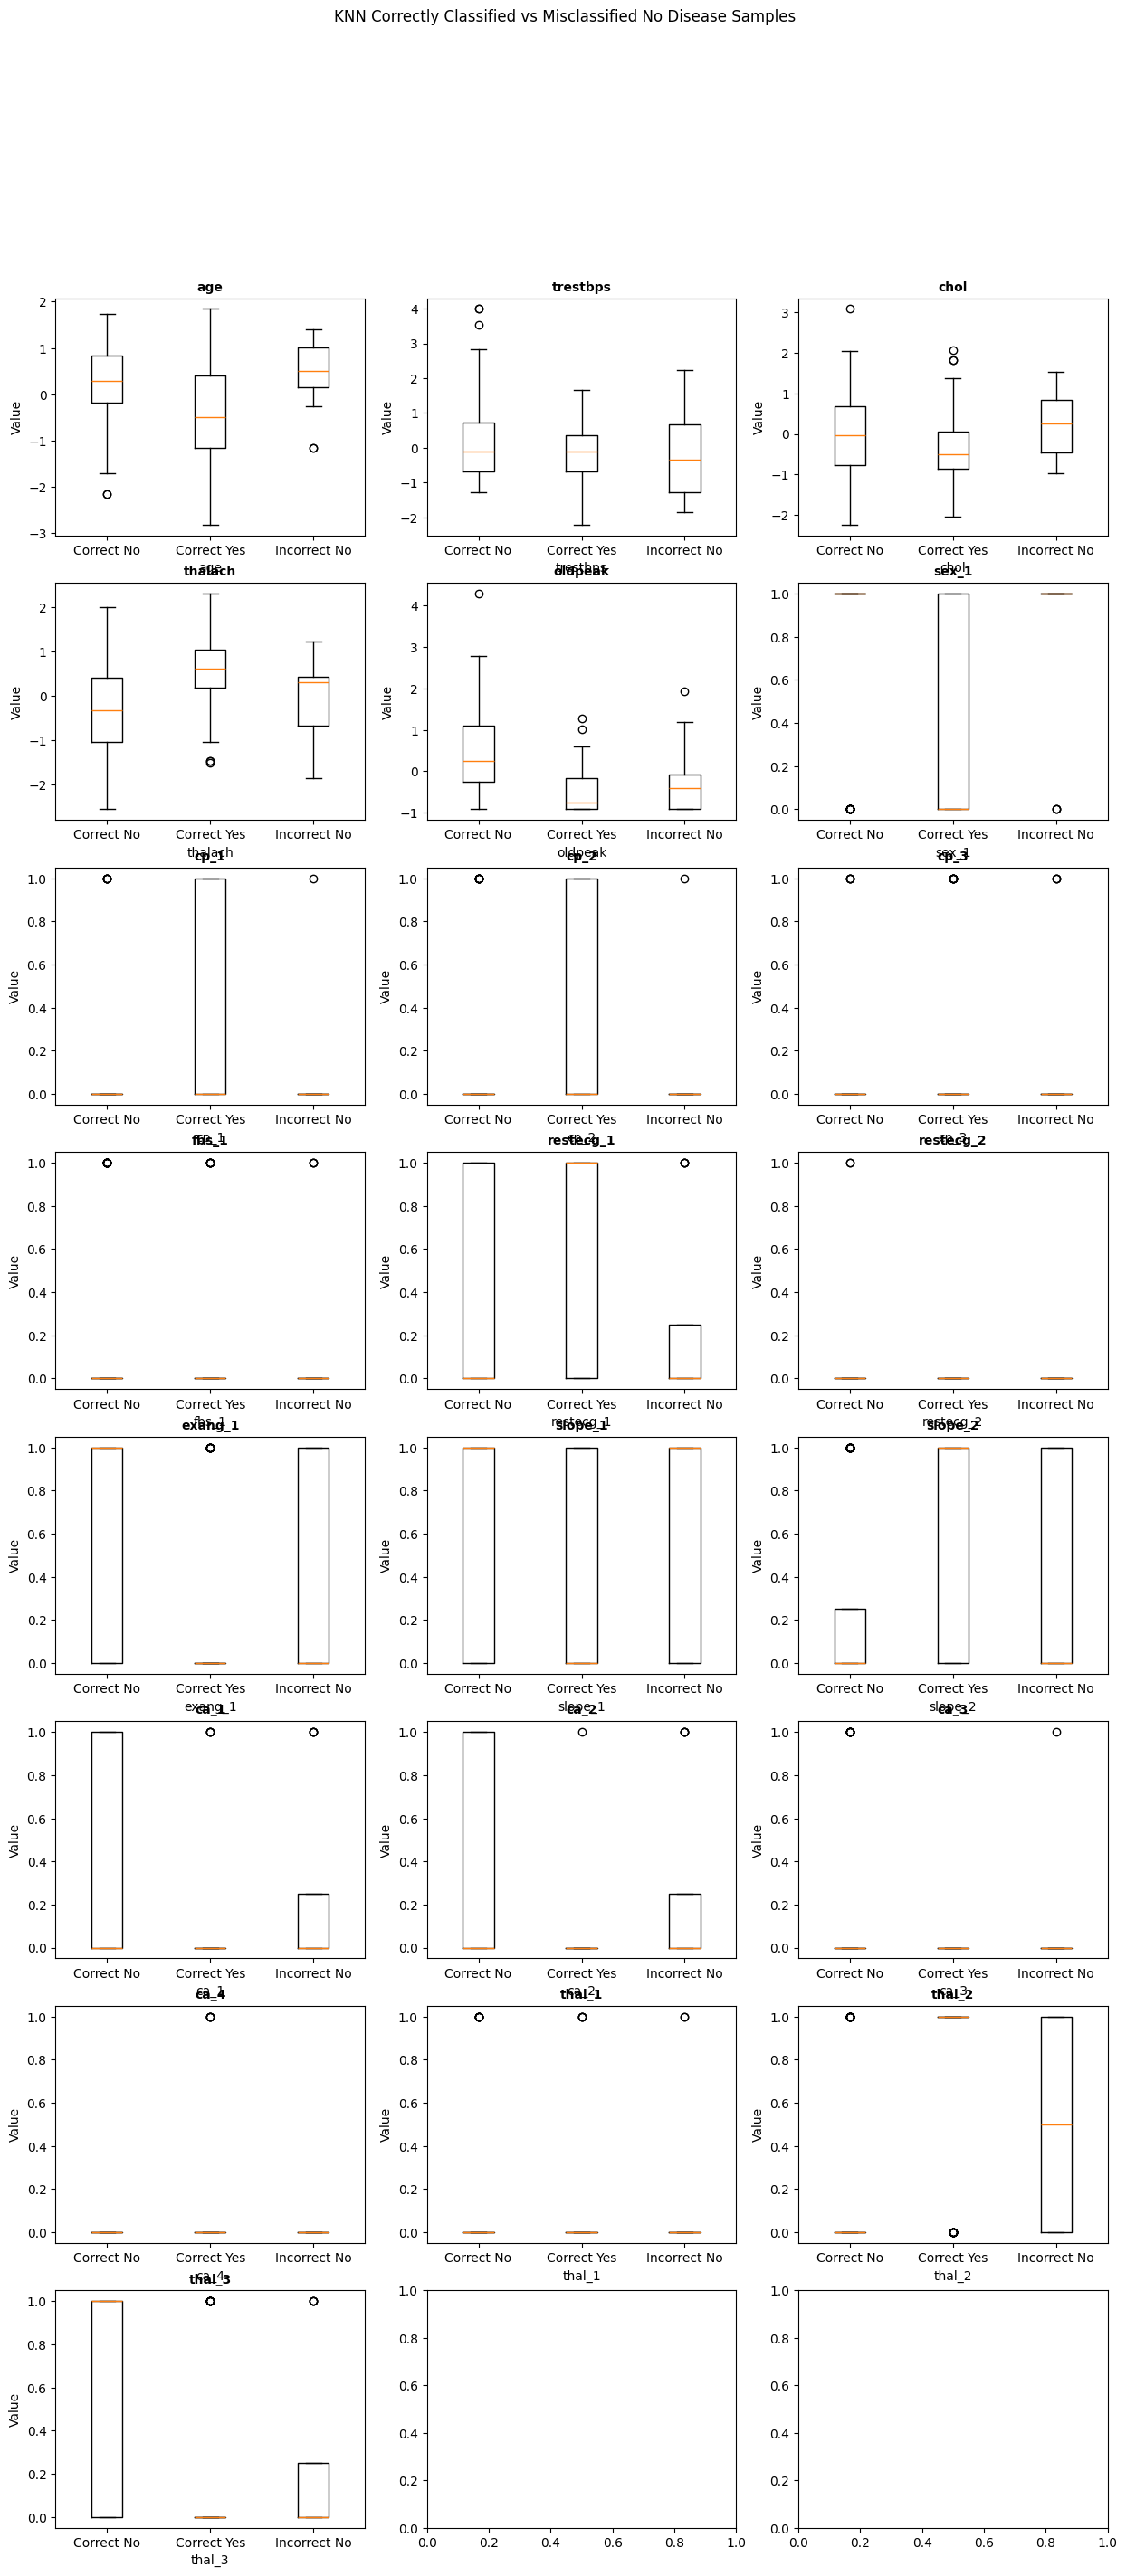

In [85]:
# Error analysis for knn
misclassified_indices = np.where(y_test != y_pred_knn)[0]

# misclassified as disease (false negative)
misclassified_no_disease_indices = misclassified_indices[y_test.iloc[misclassified_indices] == 0]
misclassified_no_disease_samples = X_test_enc.iloc[misclassified_no_disease_indices]

# correctly classified samples
correct_indices = np.where(y_test == y_pred_knn)[0]
# correctly classified as having disease
correct_disease_indices = correct_indices[y_test.iloc[correct_indices] == 1]
correct_disease_samples = X_test_enc.iloc[correct_disease_indices]
# correctly classified as no disease
correct_no_disease_indices = correct_indices[y_test.iloc[correct_indices] == 0]
correct_no_disease_samples = X_test_enc.iloc[correct_no_disease_indices]

print("Error analysis for Decision Tree")
display(misclassified_no_disease_samples.describe())

# plot misclassified disease (false negative) vs correct for all features
# 22 columns
fig, axes = plt.subplots(8, 3, figsize=(15, 32))
plt.suptitle('KNN Correctly Classified vs Misclassified No Disease Samples')
for i, col in enumerate(X_test_enc.columns):
    ax = axes[i // 3, i % 3]
    ax.boxplot([correct_no_disease_samples[col], correct_disease_samples[col], misclassified_no_disease_samples[col]],
               labels=['Correct No', 'Correct Yes', 'Incorrect No'])
    ax.set_title(col, fontweight='bold', fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel('Value')